In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_1099837/1540943805.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Logistic Regression

In [2]:
metrics=[]

## Only Text

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load your datasets
train = pd.read_csv("data_train_preprocessed.csv", keep_default_na=False)
val = pd.read_csv("data_val_preprocessed.csv", keep_default_na=False)  # Correctly loading validation data
test = pd.read_csv("data_test_preprocessed.csv", keep_default_na=False)

vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(train["processed_text_alt"])
X_val = vectorizer.transform(val["processed_text_alt"])
X_test = vectorizer.transform(test["processed_text_alt"])

y_train = train["binary_labels"]
y_val = val["binary_labels"]
y_test = test["binary_labels"]

# Initialize the Logistic Regression Classifier
log_reg = LogisticRegression(random_state=42, class_weight="balanced")

# Define the grid of parameters to search through
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# Fit GridSearchCV using validation set
grid_search.fit(X_val, y_val)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score from validation set: {grid_search.best_score_}")

# Re-train the model on the full training set using the best parameters found
log_text = LogisticRegression(**grid_search.best_params_, random_state=42, class_weight="balanced")
log_text.fit(X_train, y_train)

# Make predictions on the test set
pred_test = log_text.predict(X_test)

# Evaluate the model
print(f"Accuracy on test set: {accuracy_score(y_test, pred_test)}")
print(f"Precision on test set: {precision_score(y_test, pred_test, average='binary')}")
print(f"Recall on test set: {recall_score(y_test, pred_test, average='binary')}")
print(f"F1-Score on test set: {f1_score(y_test, pred_test, average='binary')}")


text_metrics={
    "Model": "Logistic Regression",
    "Data": "Text",
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test),
    "Recall": recall_score(y_test, pred_test),
    "F1-Score":f1_score(y_test, pred_test)
}

metrics.append(text_metrics)

# Classification Report on test set
print("Classification Report on Test Set:")
print(classification_report(y_test, pred_test))


Best parameters found: {'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}
Best score from validation set: 0.6376738729679907
Accuracy on test set: 0.7231638418079096
Precision on test set: 0.5915492957746479
Recall on test set: 0.6774193548387096
F1-Score on test set: 0.631578947368421
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       230
           1       0.59      0.68      0.63       124

    accuracy                           0.72       354
   macro avg       0.70      0.71      0.70       354
weighted avg       0.73      0.72      0.73       354



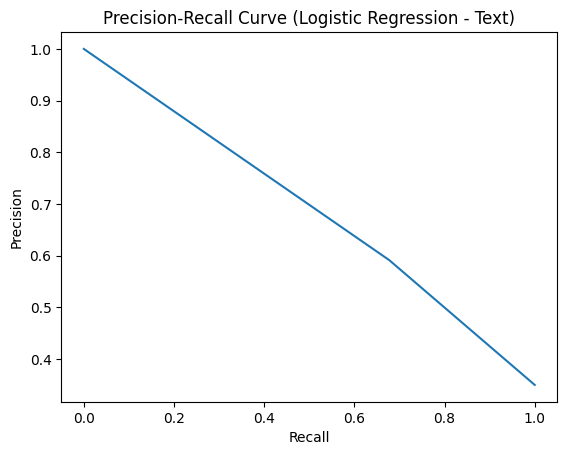

In [4]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=pred_test)

plt.figure()
plt.title("Precision-Recall Curve (Logistic Regression - Text)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall,precision)
plt.savefig("plots/Luca/Precision-Recall-LogReg-Text.png")

## Lime

In [5]:
# Assuming the vectorizer and rf model are already defined and trained
c = make_pipeline(vectorizer, log_text)

# Load test data
test = pd.read_csv("data_test_preprocessed.csv", keep_default_na=False)

# Initialize LimeTextExplainer outside the loop for efficiency
class_names = ['Not Harmful', 'Harmful']
explainer = LimeTextExplainer(class_names=class_names)

# Use batch prediction if possible (not directly supported by LIME)
# Here, predicting probabilities for all instances first for efficiency
probs = c.predict_proba(test["processed_text_alt"])

# Collecting explanations
df_pred = []
for idx, text in enumerate(test["processed_text_alt"]):
    exp = explainer.explain_instance(text, c.predict_proba, num_features=5, labels=[1])
    dict_pred = {
        "id": idx,
        "Prob (Harmful)": probs[idx, 1],
        "True Class": class_names[test["binary_labels"].iloc[idx]],
        "Explainers": exp.as_list(label=1)
    }
    df_pred.append(dict_pred)

df_pred = pd.DataFrame(df_pred)
df_pred["Prob Class"] = np.where(df_pred["Prob (Harmful)"] >= 0.5, "Harmful", "Not Harmful")

# Transforming explanations into a more useful structure
explainer_list = []
for idx, explainers in enumerate(df_pred["Explainers"]):
    for word, value in explainers:
        explainer_dict = {
            "id": idx,
            "word": word,
            "value": value
        }
        explainer_list.append(explainer_dict)
        
explainer_list = pd.DataFrame(explainer_list)
explainer_df_text = explainer_list.merge(df_pred[['id', 'Prob (Harmful)', 'Prob Class', 'True Class']], on="id")
explainer_df_text


,id,word,value,Prob (Harmful),Prob Class,True Class
0,0,trump,0.015325,0.508983,Harmful,Not Harmful
1,0,2020,-0.005340,0.508983,Harmful,Not Harmful
2,0,vaccine,0.003510,0.508983,Harmful,Not Harmful
3,0,dis,-0.002223,0.508983,Harmful,Not Harmful
4,0,tomorrow,-0.002176,0.508983,Harmful,Not Harmful
...,...,...,...,...,...,...
1632,353,home,-0.008734,0.487837,Not Harmful,Not Harmful
1633,353,quarantine,-0.005311,0.487837,Not Harmful,Not Harmful
1634,353,vaccine,0.004164,0.487837,Not Harmful,Not Harmful
1635,353,kuch,0.004157,0.487837,Not Harmful,Not Harmful


# Objects

In [6]:
# Load your datasets
train = pd.read_csv("data/train_text_and_objects.csv", keep_default_na=False)
val = pd.read_csv("data/val_text_and_objects.csv", keep_default_na=False)  # Correctly loading validation data
test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)

vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(train["objects"])
X_val = vectorizer.transform(val["objects"])
X_test = vectorizer.transform(test["objects"])

y_train = train["binary_labels"]
y_val = val["binary_labels"]
y_test = test["binary_labels"]

# Initialize the Logistic Regression Classifier
log_reg = LogisticRegression(random_state=42, class_weight="balanced")

# Define the grid of parameters to search through
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# Fit GridSearchCV using validation set
grid_search.fit(X_val, y_val)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score from validation set: {grid_search.best_score_}")

# Re-train the model on the full training set using the best parameters found
log_objects = LogisticRegression(**grid_search.best_params_, random_state=42, class_weight="balanced")
log_objects.fit(X_train, y_train)

# Make predictions on the test set
pred_test = log_objects.predict(X_test)

# Evaluate the model
print(f"Accuracy on test set: {accuracy_score(y_test, pred_test)}")
print(f"Precision on test set: {precision_score(y_test, pred_test, average='binary')}")
print(f"Recall on test set: {recall_score(y_test, pred_test, average='binary')}")
print(f"F1-Score on test set: {f1_score(y_test, pred_test, average='binary')}")


object_metrics={
    "Model": "Random Forest",
    "Data": "Objects",
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test),
    "Recall": recall_score(y_test, pred_test),
    "F1-Score":f1_score(y_test, pred_test)
}

metrics.append(object_metrics)

# Classification Report on test set
print("Classification Report on Test Set:")
print(classification_report(y_test, pred_test))


Best parameters found: {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Best score from validation set: 0.6239613526570048
Accuracy on test set: 0.6073446327683616
Precision on test set: 0.46153846153846156
Recall on test set: 0.7258064516129032
F1-Score on test set: 0.5642633228840125
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.79      0.54      0.64       230
           1       0.46      0.73      0.56       124

    accuracy                           0.61       354
   macro avg       0.62      0.63      0.60       354
weighted avg       0.67      0.61      0.62       354



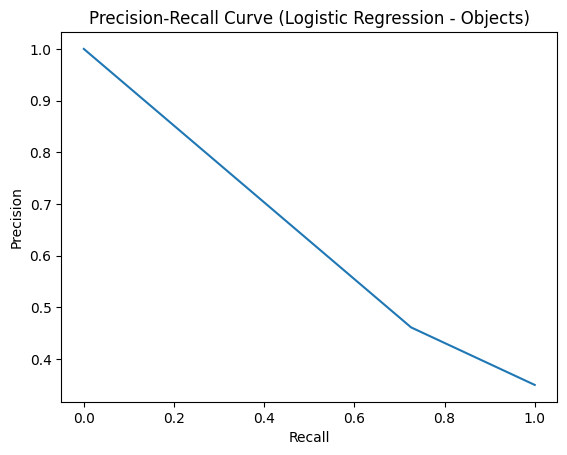

In [7]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=pred_test)

plt.figure()
plt.title("Precision-Recall Curve (Logistic Regression - Objects)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall,precision)
plt.savefig("plots/Luca/Precision-Recall-LogReg-Objects.png")

## Lime

In [8]:
# Assuming the vectorizer and rf model are already defined and trained
c = make_pipeline(vectorizer, log_objects)

# Load test data
test = pd.read_csv('data/test_text_and_objects.csv', keep_default_na=False)

# Initialize LimeTextExplainer outside the loop for efficiency
class_names = ['Not Harmful', 'Harmful']
explainer = LimeTextExplainer(class_names=class_names)

# Use batch prediction if possible (not directly supported by LIME)
# Here, predicting probabilities for all instances first for efficiency
probs = c.predict_proba(test["objects"])

df_pred = []
for idx, text in enumerate(test["objects"]):
    # Ensure the text is valid and non-empty
    if text and len(text.split()) > 0:
        exp = explainer.explain_instance(text, c.predict_proba, num_features=5, labels=[1])
        #print('Document id: %d' % idx)
        dict_pred = {
            "id": idx,
            "Prob (Harmful)": probs[idx, 1],
            "True Class": class_names[test["binary_labels"].iloc[idx]],
            "Explainers": exp.as_list(label=1)
        }
        df_pred.append(dict_pred)
    else:
        print(f'Skipping document id: {idx} due to insufficient text')
        

df_pred = pd.DataFrame(df_pred)
df_pred["Prob Class"] = np.where(df_pred["Prob (Harmful)"] >= 0.5, "Harmful", "Not Harmful")

# Transforming explanations into a more useful structure
explainer_list = []
for idx, explainers in enumerate(df_pred["Explainers"]):
    for word, value in explainers:
        explainer_dict = {
            "id": idx,
            "word": word,
            "value": value
        }
        explainer_list.append(explainer_dict)
        
explainer_list = pd.DataFrame(explainer_list)
explainer_df_objects = explainer_list.merge(df_pred[['id', 'Prob (Harmful)', 'Prob Class', 'True Class']], on="id")
explainer_df_objects


Skipping document id: 0 due to insufficient text
Skipping document id: 33 due to insufficient text
Skipping document id: 55 due to insufficient text
Skipping document id: 56 due to insufficient text
Skipping document id: 83 due to insufficient text
Skipping document id: 92 due to insufficient text
Skipping document id: 97 due to insufficient text
Skipping document id: 101 due to insufficient text
Skipping document id: 106 due to insufficient text
Skipping document id: 115 due to insufficient text
Skipping document id: 117 due to insufficient text
Skipping document id: 119 due to insufficient text
Skipping document id: 134 due to insufficient text
Skipping document id: 160 due to insufficient text
Skipping document id: 165 due to insufficient text
Skipping document id: 172 due to insufficient text
Skipping document id: 176 due to insufficient text
Skipping document id: 198 due to insufficient text
Skipping document id: 220 due to insufficient text
Skipping document id: 225 due to insuff

,id,word,value,Prob (Harmful),Prob Class,True Class
0,1,tie,0.196830,0.415746,Not Harmful,Not Harmful
1,1,person,-0.023030,0.415746,Not Harmful,Not Harmful
2,2,tie,0.197417,0.758290,Harmful,Not Harmful
3,2,person,-0.022426,0.758290,Harmful,Not Harmful
4,3,tie,0.169264,0.758290,Harmful,Not Harmful
...,...,...,...,...,...,...
599,318,person,0.058473,0.533401,Harmful,Not Harmful
600,320,person,0.106084,0.533401,Harmful,Not Harmful
601,320,bed,-0.054234,0.533401,Harmful,Not Harmful
602,320,chair,-0.050586,0.533401,Harmful,Not Harmful


# Text and Objects

In [9]:

# Load your datasets
train = pd.read_csv("data/train_text_and_objects.csv", keep_default_na=False)
val = pd.read_csv("data/val_text_and_objects.csv", keep_default_na=False)  # Correctly loading validation data
test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)

vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(train["text_and_objects"])
X_val = vectorizer.transform(val["text_and_objects"])
X_test = vectorizer.transform(test["text_and_objects"])

y_train = train["binary_labels"]
y_val = val["binary_labels"]
y_test = test["binary_labels"]

# Initialize the Logistic Regression Classifier
log_reg = LogisticRegression(random_state=42, class_weight="balanced")

# Define the grid of parameters to search through
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')

# Fit GridSearchCV using validation set
grid_search.fit(X_val, y_val)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score from validation set: {grid_search.best_score_}")

# Re-train the model on the full training set using the best parameters found
log_text_objects = LogisticRegression(**grid_search.best_params_, random_state=42, class_weight="balanced")
log_text_objects.fit(X_train, y_train)

# Make predictions on the test set
pred_test = log_text_objects.predict(X_test)

# Evaluate the model
print(f"Accuracy on test set: {accuracy_score(y_test, pred_test)}")
print(f"Precision on test set: {precision_score(y_test, pred_test, average='binary')}")
print(f"Recall on test set: {recall_score(y_test, pred_test, average='binary')}")
print(f"F1-Score on test set: {f1_score(y_test, pred_test, average='binary')}")


text_objects_metrics={
    "Model": "Random Forest",
    "Data": "Text and Objects",
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test),
    "Recall": recall_score(y_test, pred_test),
    "F1-Score":f1_score(y_test, pred_test)
}

metrics.append(text_objects_metrics)

# Classification Report on test set
print("Classification Report on Test Set:")
print(classification_report(y_test, pred_test))


Best parameters found: {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}
Best score from validation set: 0.7378258286186675
Accuracy on test set: 0.7457627118644068
Precision on test set: 0.5965909090909091
Recall on test set: 0.8467741935483871
F1-Score on test set: 0.7
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       230
           1       0.60      0.85      0.70       124

    accuracy                           0.75       354
   macro avg       0.74      0.77      0.74       354
weighted avg       0.79      0.75      0.75       354



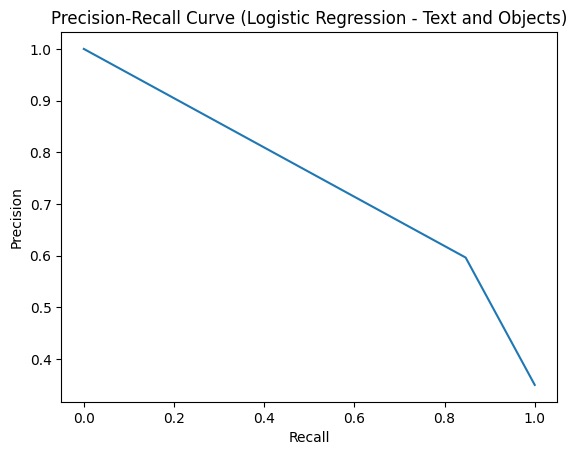

In [10]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=pred_test)

plt.figure()
plt.title("Precision-Recall Curve (Logistic Regression - Text and Objects)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall,precision)
plt.savefig("plots/Luca/Precision-Recall-LogReg-Text-Objects.png")

## Lime

In [11]:
# Assuming the vectorizer and rf model are already defined and trained
c = make_pipeline(vectorizer, log_text_objects)

# Load test data
test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)

# Initialize LimeTextExplainer outside the loop for efficiency
class_names = ['Not Harmful', 'Harmful']
explainer = LimeTextExplainer(class_names=class_names)

# Use batch prediction if possible (not directly supported by LIME)
# Here, predicting probabilities for all instances first for efficiency
probs = c.predict_proba(test["text_and_objects"])

# Collecting explanations
df_pred = []
for idx, text in enumerate(test["text_and_objects"]):
    exp = explainer.explain_instance(text, c.predict_proba, num_features=5, labels=[1])
    dict_pred = {
        "id": idx,
        "Prob (Harmful)": probs[idx, 1],
        "True Class": class_names[test["binary_labels"].iloc[idx]],
        "Explainers": exp.as_list(label=1)
    }
    df_pred.append(dict_pred)

df_pred = pd.DataFrame(df_pred)
df_pred["Prob Class"] = np.where(df_pred["Prob (Harmful)"] >= 0.5, "Harmful", "Not Harmful")

# Transforming explanations into a more useful structure
explainer_list = []
for idx, explainers in enumerate(df_pred["Explainers"]):
    for word, value in explainers:
        explainer_dict = {
            "id": idx,
            "word": word,
            "value": value
        }
        explainer_list.append(explainer_dict)
        
explainer_list = pd.DataFrame(explainer_list)
explainer_df_text_objects = explainer_list.merge(df_pred[['id', 'Prob (Harmful)', 'Prob Class', 'True Class']], on="id")
explainer_df_text_objects


,id,word,value,Prob (Harmful),Prob Class,True Class
0,0,trump,0.014136,0.505549,Harmful,Not Harmful
1,0,2020,-0.004779,0.505549,Harmful,Not Harmful
2,0,vaccine,0.003457,0.505549,Harmful,Not Harmful
3,0,dis,-0.002091,0.505549,Harmful,Not Harmful
4,0,tomorrow,-0.002088,0.505549,Harmful,Not Harmful
...,...,...,...,...,...,...
1721,353,home,-0.006925,0.488253,Not Harmful,Not Harmful
1722,353,person,0.006505,0.488253,Not Harmful,Not Harmful
1723,353,quarantine,-0.004150,0.488253,Not Harmful,Not Harmful
1724,353,vaccine,0.003677,0.488253,Not Harmful,Not Harmful


# Metric overview

In [12]:
metrics = pd.DataFrame(metrics)
metrics_values = metrics[["Data","Accuracy","Precision","Recall","F1-Score"]]

df_melted = metrics_values.melt('Data', var_name='Metrics', value_name='Values')
df_melted

,Data,Metrics,Values
0,Text,Accuracy,0.723164
1,Objects,Accuracy,0.607345
2,Text and Objects,Accuracy,0.745763
3,Text,Precision,0.591549
4,Objects,Precision,0.461538
5,Text and Objects,Precision,0.596591
6,Text,Recall,0.677419
7,Objects,Recall,0.725806
8,Text and Objects,Recall,0.846774
9,Text,F1-Score,0.631579


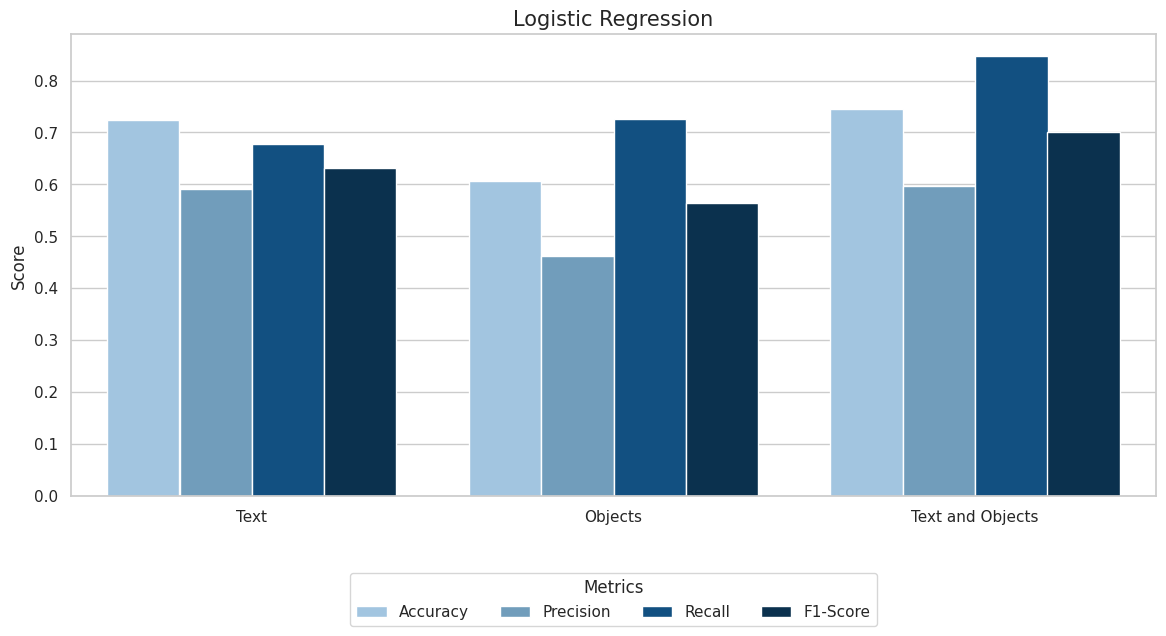

In [15]:
# Function to plot the data
def plot_metrics(df, color_dict):
    sns.set(style="whitegrid")
    # Melting the dataframe to have proper format for seaborn
    df_melted = df.melt('Data', var_name='Metrics', value_name='Values')
    plt.figure(figsize=(14, 6))
    # Creating the barplot
    barplot = sns.barplot(x='Data', y='Values', hue='Metrics', data=df_melted, palette=color_dict)
    # Customizing the plot
    barplot.set_title('Logistic Regression', fontsize=15)
    barplot.set_xlabel('', fontsize=12)
    barplot.set_ylabel('Score', fontsize=12)
    plt.legend(title='Metrics', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)    # Display the plot
    plt.savefig("plots/Luca/Metrics-LogReg.png",bbox_inches='tight')

custom_colors = {
    'Accuracy': '#98C6EA',  # Replace '#1f77b4' with your desired hex color code for Accuracy
    'Precision': '#64A0C8',  # Replace '#ff7f0e' with your desired hex color code for Precision
    'Recall': '#005293',    # Replace '#2ca02c' with your desired hex color code for Recall
    'F1-Score': '#003359'   # Replace '#d62728' with your desired hex color code for F1-Score
}

plot_metrics(metrics_values, custom_colors)

# Lime

In [ ]:
data = [explainer_df_text,explainer_df_objects,explainer_df_text_objects]
txt = ["Text","Objects","Text and Objects"]
file=["Text","Objects","Text_Objects"]


for i in range(0,3):
    df = data[i]
    type = txt[i]
    file_spec=file[i]
    model = "LogReg"

    df=df[["word","value"]].groupby("word").mean("value")
    df["direction"] = np.where(df["value"]>0,"harmful","harmless")

    exp_p = df[df["direction"]=="harmful"].sort_values("value",ascending=False).head(10)
    exp_n = df[df["direction"]=="harmless"].sort_values("value",ascending=True).head(10)
    exp_n["value"]=exp_n["value"]*-1

    plt.figure(figsize=(10, 6))
    sns.barplot(y=exp_p.index, x='value',hue="direction" , data=exp_p, palette=["#003359"])

    # Adding legend and labels
    plt.legend(title='Result')
    plt.ylabel('Word')
    plt.xlabel('Count')
    plt.title(f'Top 10 words from the {type} by average explaining value for Meme being harmful')
    plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

    # Display the plot
    plt.savefig(f"plots/Luca/Lime/{model}-Lime-{file_spec}-Positive.jpeg")

    plt.figure(figsize=(10, 6))
    sns.barplot(y=exp_n.index, x='value',hue="direction" , data=exp_n, palette=["#A2AD00"])

    # Adding legend and labels
    plt.legend(title='Result')
    plt.ylabel('Word')
    plt.xlabel('Value')
    plt.title(f'Top 10 words from the {type} by average explaining value for Meme being harmless')
    plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

    # Display the plot
    plt.savefig(f"plots/Luca/Lime/{model}-Lime-{file_spec}-Negative.jpeg")
